<a href="https://colab.research.google.com/github/Enterprise-D/sc_multimodal/blob/main/multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Colab Administrative

Mount Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Compression

Install and load h5df modules:

In [ ]:
import h5py

!pip install hdf5plugin
import hdf5plugin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.9 MB 22.9 MB/s 


handle inputs:

In [ ]:
path_train_multi_inputs = '/content/drive/MyDrive/multimodal/train_multi_inputs.h5'
file_train_multi_inputs = h5py.File(path_train_multi_inputs, "r")

path_test_multi_inputs = '/content/drive/MyDrive/multimodal/test_multi_inputs.h5'
file_test_multi_inputs = h5py.File(path_test_multi_inputs, "r")

file_train_multi_inputs.keys(), file_test_multi_inputs.keys()

(<KeysViewHDF5 ['train_multi_inputs']>, <KeysViewHDF5 ['test_multi_inputs']>)

In [ ]:
group_train_multi_inputs = file_train_multi_inputs['train_multi_inputs']

group_test_multi_inputs = file_test_multi_inputs['test_multi_inputs']

group_train_multi_inputs.keys(), group_test_multi_inputs.keys()

(<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>,
 <KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>)

In [ ]:
group_train_multi_inputs['block0_values'].shape, \
group_test_multi_inputs['block0_values'].shape
# axis0 & block0_items: features (genomic coordinates, GRCh38)
# axis1: cell_ids
# block0_values: entries

((105942, 228942), (55935, 228942))

In [ ]:
group_train_multi_inputs['block0_values'][0:10,0:6]

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

handle targets:

In [ ]:
path_train_multi_targets = '/content/drive/MyDrive/multimodal/train_multi_targets.h5'
file_train_multi_targets = h5py.File(path_train_multi_targets, "r")

file_train_multi_targets.keys()

<KeysViewHDF5 ['train_multi_targets']>

In [ ]:
group_train_multi_targets = file_train_multi_targets['train_multi_targets']
group_train_multi_targets.keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>

In [ ]:
group_train_multi_targets['block0_values'].shape
# axis0 & block0_items: features (expression reads, GRCh38)
# axis1: cell_ids
# block0_values: entries

(105942, 23418)

In [ ]:
group_train_multi_targets['block0_values'][0:10,0:6]

array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 4.5079365, 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy.sparse as sps
from tqdm import tqdm as tqdm
import gc

Compress dataset (code adapted from [reduce-memory-usage-by-95-with-sparse-matrices](https://www.kaggle.com/code/sbunzini/reduce-memory-usage-by-95-with-sparse-matrices)):

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import cython
cimport cython
cimport numpy as np
import numpy as np
from tqdm import tqdm, trange

ctypedef np.int64_t INT64_t

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef np.ndarray[INT64_t, ndim=1] create_indptr(INT64_t[:] row_indices, int start_pos, int nrows):
    cdef int shape = row_indices.shape[0]
    res = np.zeros(nrows, dtype=np.int64)
    cdef INT64_t[:] res_view = res
    
    cdef int i
    cdef int curr_row = 0
    cdef int prev = row_indices[0]
    
    for i in range(shape):
        if row_indices[i] != prev:
            curr_row += 1
            res_view[curr_row] = i
            prev = row_indices[i]
    # res_view[curr_row + 1] = shape
    return res + start_pos

In [ ]:
def create_csr_arrays(h5_file_path):
    def check_size(xs, ys, datas):
        return (xs.nbytes + ys.nbytes + datas.nbytes) * 1e-9

    print(f"\n\nProcessing File {h5_file_path}")
    pbar = tqdm()

    # Initialize Variables
    chunksize = 1000 # Keep it low
    loaded_rows = chunksize
    start = 0
    start_pos = 0
    file_pointer = 0

    # Initialize CSR arrays
    indptr = np.array([], dtype=np.int64)
    indices = np.array([], dtype=np.int32)
    data_s = np.array([], dtype=np.float32)
    
    prefix_filename = h5_file_path.split('/')[-1].replace('.h5', '')

    while chunksize == loaded_rows:

        # Check current size: if the total sum of sizes are > 7GB, then save three arrays and re-initialize them
        size_gb = check_size(indptr, indices, data_s)
        if size_gb > 7.0:
            pbar.set_description(f"Total size is {size_gb}. Saving ..")
            np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
            np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
            np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
            # Re-initialize
            indptr = np.array([], dtype=np.int64)
            indices = np.array([], dtype=np.int32)
            data_s = np.array([], dtype=np.float32)
            # Increment pointer
            file_pointer += 1

        pbar.set_description("Reading .h5 chunk")
        df = pd.read_hdf(h5_file_path, start=start, stop=start+chunksize)
        pbar.set_description("Extracting non-zero values")
        x_coords, y_coords = df.values.nonzero()
        tmp_data = df.values[df.values != 0.0]

        loaded_rows = df.shape[0]

        # Convert types
        y_coords = y_coords.astype(np.int32, copy=False)
        tmp_data = tmp_data.astype(np.float32, copy=False)

        # Compress x_coords
        pbar.set_description("Compressing rows values")
        x_coords = create_indptr(x_coords, start_pos=start_pos, nrows=loaded_rows)

        gc.collect()

        # Update variables
        pbar.set_description("Update variables")
        start_pos += y_coords.shape[0]
        start += chunksize
        # Append data at the end of each array
        indptr = np.hstack((indptr, x_coords))
        indices = np.hstack((indices, y_coords))
        data_s = np.hstack((data_s, tmp_data))

        pbar.update(loaded_rows)

    print('Done. Save last files')
    np.save(f"{prefix_filename}_indptr_{file_pointer}.npy", indptr)
    np.save(f"{prefix_filename}_indices_{file_pointer}.npy", indices)
    np.save(f"{prefix_filename}_data_{file_pointer}.npy", data_s)
    
    del indptr, indices, data_s

In [ ]:
create_csr_arrays(path_train_multi_inputs)



Processing File /content/drive/MyDrive/multimodal/train_multi_inputs.h5


Update variables: : 105942it [24:03, 61.93it/s]

Done. Save last files


Update variables: : 105942it [24:14, 72.84it/s]


In [ ]:
indptr = np.load('train_multi_inputs_indptr_0.npy')
indices = np.load('train_multi_inputs_indices_0.npy')
data = np.load('train_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_inputs['block0_values'].shape[0]
N_COLS = group_train_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_train_multi_targets)



Processing File /content/drive/MyDrive/multimodal/train_multi_targets.h5


Update variables: : 105942it [03:37, 446.31it/s]

Done. Save last files


Update variables: : 105942it [03:44, 471.47it/s]


In [ ]:
indptr = np.load('train_multi_targets_indptr_0.npy')
indices = np.load('train_multi_targets_indices_0.npy')
data = np.load('train_multi_targets_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_train_multi_targets['block0_values'].shape[0]
N_COLS = group_train_multi_targets['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('train_multi_targets_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
create_csr_arrays(path_test_multi_inputs)



Processing File /content/drive/MyDrive/multimodal/test_multi_inputs.h5


Update variables: : 55935it [14:53, 58.34it/s]

Done. Save last files


Update variables: : 55935it [14:59, 62.21it/s]


In [ ]:
indptr = np.load('test_multi_inputs_indptr_0.npy')
indices = np.load('test_multi_inputs_indices_0.npy')
data = np.load('test_multi_inputs_data_0.npy')
indptr = np.append(indptr, indptr[-1] + indices[indptr[-1]:].shape)
N_ROWS = group_test_multi_inputs['block0_values'].shape[0]
N_COLS = group_test_multi_inputs['block0_values'].shape[1]
csr_matrix = sps.csr_matrix((data, indices, indptr), shape=(N_ROWS, N_COLS))
sps.save_npz('test_multi_inputs_sparse.npz', csr_matrix)
del csr_matrix, indices, indptr, data

In [ ]:
!mv *.npy /content/drive/MyDrive/multimodal_sparse
!mv *.npz /content/drive/MyDrive/multimodal_sparse

## Preprocessing

In [ ]:
import random
import joblib
import numpy as np
import pandas as pd
from sklearn import decomposition, model_selection, preprocessing

import os
import gc
import scipy.sparse as sps
from tqdm import tqdm as tqdm

Fix random seeds:

In [ ]:
random_seed = 3407
random.seed(random_seed)
np.random.seed(random_seed)

### Split datasets into training and validation parts:

Copy data to local disk and load into python:

In [ ]:
!cp /content/drive/MyDrive/multimodal_sparse/*.npz /content/

In [ ]:
input_csr = sps.load_npz('/content/train_multi_inputs_sparse.npz')

In [ ]:
target_csr = sps.load_npz('/content/train_multi_targets_sparse.npz')

In [ ]:
input_csr.shape, target_csr.shape

((105942, 228942), (105942, 23418))

Non-zero entries:

In [ ]:
input_csr.count_nonzero()/input_csr.shape[0]/input_csr.shape[1]

0.025038640626076362

In [ ]:
target_csr.count_nonzero()/target_csr.shape[0]/target_csr.shape[1]

0.1640601040047826

In [ ]:
! rm *.npz

Split datasets in advance to prevent model from seeing validation data:

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(input_csr,
                                                                    target_csr, 
                                                                    test_size=0.2, 
                                                                    random_state = random_seed)
del input_csr, target_csr

sps.save_npz('X_train.npz', X_train)
del X_train

sps.save_npz('X_test.npz', X_test)
del X_test

sps.save_npz('y_train.npz', y_train)
del y_train

sps.save_npz('y_test.npz', y_test)
del y_test

In [ ]:
!cp *.npz /content/drive/MyDrive/multimodal_split

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/*.npz /content/

### Feature Selection

In [ ]:
!pip install -U matplotlib
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import scanpy as sc
import anndata

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/*.npz /content/

train_target = sps.load_npz('y_train.npz')
anndata_train_target = anndata.AnnData(train_target)

sc.pp.highly_variable_genes(anndata_train_target, min_mean=0.0125, max_mean=8, min_disp=0.5, n_top_genes = 2048)

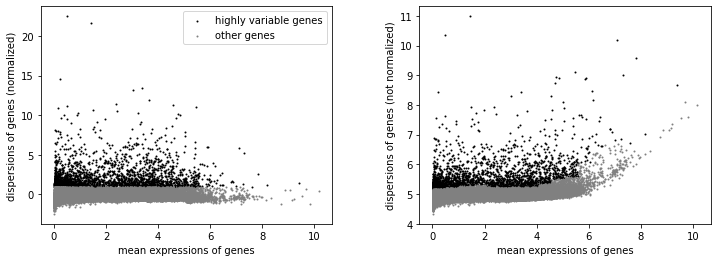

In [ ]:
sc.pl.highly_variable_genes(anndata_train_target)

In [ ]:
valid_target = sps.load_npz('y_test.npz')
anndata_valid_target = anndata.AnnData(valid_target)

In [ ]:
# use the same HVGs
anndata_valid_target = anndata_valid_target[:, anndata_train_target.var.highly_variable]
valid_target_hvg = anndata_valid_target.X

anndata_train_target = anndata_train_target[:, anndata_train_target.var.highly_variable]
train_target_hvg = anndata_train_target.X

anndata_train_target

View of AnnData object with n_obs × n_vars = 84753 × 2048
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [ ]:
sps.save_npz('y_train_hvg.npz', train_target_hvg)
sps.save_npz('y_test_hvg.npz', valid_target_hvg)

!mv y_train_hvg.npz /content/drive/MyDrive/multimodal_split
!mv y_test_hvg.npz /content/drive/MyDrive/multimodal_split

In [ ]:
hvg_index = anndata_train_target.var.highly_variable.index
np.save('/content/drive/MyDrive/hvg_index.npy', hvg_index)

hvg_index

Index(['2', '13', '18', '33', '38', '40', '41', '42', '56', '57',
       ...
       '22999', '23001', '23003', '23036', '23094', '23220', '23243', '23316',
       '23377', '23401'],
      dtype='object', length=2048)

### Truncated SVD (all features)

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/*.npz /content/

In [ ]:
train_input= sps.load_npz('X_train.npz')

# be careful with memory quota
tsvd_input = decomposition.TruncatedSVD(n_components=512,algorithm='arpack',random_state=random_seed)
U_train_input = tsvd_input.fit_transform(train_input)
Va_train_input = tsvd_input.components_

np.save("U_train_input.npy", U_train_input)
np.save("Va_train_input.npy", Va_train_input)

del train_input

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
valid_input = sps.load_npz('X_test.npz')

U_valid_input = tsvd_input.transform(valid_input)
Va_valid_input = tsvd_input.components_

np.save("U_valid_input.npy", U_valid_input)
np.save("Va_valid_input.npy", Va_valid_input)

joblib.dump(tsvd_input, '/content/drive/MyDrive/multimodal_tsvd/tsvd_input.pkl')

del valid_input, tsvd_input

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
# be careful with memory quota
train_target = sps.load_npz('y_train.npz')

#redistributor = preprocessing.PowerTransformer()
#train_target = redistributor.fit_transform(train_target)

normalizer = preprocessing.Normalizer()
train_target = normalizer.fit_transform(train_target)

tsvd_target = decomposition.TruncatedSVD(n_components=512,algorithm='arpack',random_state=random_seed)
U_train_target = tsvd_target.fit_transform(train_target)
Va_train_target = tsvd_target.components_

np.save("U_train_target.npy", U_train_target)
np.save("Va_train_target.npy", Va_train_target)

del train_target

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
valid_target = sps.load_npz('y_test.npz')#.toarray()

#valid_target = redistributor.transform(valid_target)
valid_target = normalizer.fit_transform(valid_target)

U_valid_target = tsvd_target.transform(valid_target)
Va_valid_target = tsvd_target.components_

np.save("U_valid_target.npy", U_valid_target)
np.save("Va_valid_target.npy", Va_valid_target)

joblib.dump(tsvd_target, '/content/drive/MyDrive/multimodal_tsvd/tsvd_target.pkl')

del valid_target, tsvd_target

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

For binarized data (input only):

In [ ]:
train_input_binary = sps.load_npz('X_train.npz')
train_input_binary[train_input_binary.nonzero()]=1

tsvd_input_binary = decomposition.TruncatedSVD(n_components=512,algorithm='arpack',random_state=random_seed)
U_train_input_binary = tsvd_input_binary.fit_transform(train_input_binary)
Va_train_input_binary = tsvd_input_binary.components_

np.save("U_train_input_binary.npy", U_train_input_binary)
np.save("Va_train_input_binary.npy", Va_train_input_binary)

del train_input_binary

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
valid_input_binary = sps.load_npz('X_test.npz')
valid_input_binary[valid_input_binary.nonzero()]=1

U_valid_input_binary = tsvd_input_binary.transform(valid_input_binary)
Va_valid_input_binary = tsvd_input_binary.components_

np.save("U_valid_input_binary.npy", U_valid_input_binary)
np.save("Va_valid_input_binary.npy", Va_valid_input_binary)

joblib.dump(tsvd_input_binary, '/content/drive/MyDrive/multimodal_tsvd/tsvd_input_binary.pkl')

del valid_input_binary, tsvd_input_binary

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

For HVGs:

In [ ]:
train_target_hvg= sps.load_npz('y_train_hvg.npz')

tsvd_target_hvg = decomposition.TruncatedSVD(n_components=256,algorithm='arpack',random_state=random_seed)

U_train_target_hvg = tsvd_target_hvg.fit_transform(train_target_hvg)
Va_train_target_hvg = tsvd_target_hvg.components_

np.save("U_train_target_hvg.npy", U_train_target_hvg)
np.save("Va_train_target_hvg.npy", Va_train_target_hvg)

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

In [ ]:
valid_target_hvg= sps.load_npz('y_test_hvg.npz')

U_valid_target_hvg = tsvd_target_hvg.transform(valid_target_hvg)
Va_valid_target_hvg = tsvd_target_hvg.components_

np.save("U_valid_target_hvg.npy", U_valid_target_hvg)
np.save("Va_valid_target_hvg.npy", Va_valid_target_hvg)

joblib.dump(tsvd_target_hvg, '/content/drive/MyDrive/multimodal_tsvd/tsvd_target_hvg.pkl')

!mv *.npy /content/drive/MyDrive/multimodal_tsvd

### Reconstruction test for target



In [ ]:
import torch

In [ ]:
U_train_target = np.load("/content/drive/MyDrive/multimodal_tsvd/U_train_target.npy")
U_valid_target = np.load("/content/drive/MyDrive/multimodal_tsvd/U_valid_target.npy")

Va_train_target = np.load("/content/drive/MyDrive/multimodal_tsvd/Va_train_target.npy")

In [ ]:
train_target = sps.load_npz('/content/drive/MyDrive/multimodal_split/y_train.npz')
valid_target = sps.load_npz('/content/drive/MyDrive/multimodal_split/y_test.npz')

In [ ]:
def pcorr_vec(X,Y):
  Xnorm = X-X.mean(axis=1).reshape(-1, 1)
  Ynorm = Y-Y.mean(axis=1).reshape(-1, 1)
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma2 = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma2 = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma2,Ysigma2))
  return torch.mean(cov/sigma)

In [ ]:
Mtrain = torch.from_numpy(train_target[0:2000].todense()).cuda()
Mvalid = torch.from_numpy(valid_target[0:2000].todense()).cuda()

Utrain = torch.from_numpy(U_train_target[0:2000]).cuda()
Uvalid = torch.from_numpy(U_valid_target[0:2000]).cuda()

Va = torch.from_numpy(Va_train_target).cuda()

In [ ]:
Atrain = torch.matmul(Utrain,Va)
Avalid = torch.matmul(Uvalid,Va)

In [ ]:
pcorr_vec(Mtrain,Atrain), pcorr_vec(Mvalid,Avalid)

(tensor(0.7108, device='cuda:0'), tensor(0.7003, device='cuda:0'))

## PyTorch Workflow (tSVD, all features)

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler

import random
import joblib
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy import stats
from sklearn import preprocessing

import matplotlib.pyplot as plt

Fix random seeds:

In [ ]:
random_seed = 3407
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Prepare files:

In [ ]:
!cp /content/drive/MyDrive/multimodal_tsvd/*.npy /content/

In [ ]:
U_train_input = np.load("U_train_input.npy")
U_train_target = np.load("U_train_target.npy")

U_valid_input = np.load("U_valid_input.npy")
U_valid_target = np.load("U_valid_target.npy")

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/y_train.npz /content/
!cp /content/drive/MyDrive/multimodal_split/y_test.npz /content/

In [ ]:
train_target = sps.load_npz('y_train.npz')
valid_target = sps.load_npz('y_test.npz')

In [ ]:
U_train_input_bin = np.load("U_train_input_binary.npy")
U_valid_input_bin = np.load("U_valid_input_binary.npy")

#### Normalize targets (for MSE calculation):

In [ ]:
U_train_input_std = U_train_input.std(axis=1).reshape(-1, 1)
U_train_input_norm = U_train_input / U_train_input_std

In [ ]:
U_valid_input_std = U_valid_input.std(axis=1).reshape(-1, 1)
U_valid_input_norm = U_valid_input / U_valid_input_std

In [ ]:
train_target_mean = np.ma.mean(np.ma.masked_equal(train_target.toarray(),0),axis=1).data
valid_target_mean = np.ma.mean(np.ma.masked_equal(valid_target.toarray(),0),axis=1).data

In [ ]:
train_target = train_target/train_target_mean.reshape(-1,1)
valid_target = valid_target/valid_target_mean.reshape(-1,1)

#### Construct dataset and dataloader:

In [ ]:
class TrainDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_train_input_norm.astype('float32')).cuda()
      self.inputs_data_bin = torch.from_numpy(U_train_input_bin.astype('float32')).cuda()

      self.targets_data_ori = torch.from_numpy(train_target.astype('float32'))
      # send to GPU as a whole due to small size.

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = torch.squeeze(self.inputs_data[idx, ...])
      inputs_sliced_bin = torch.squeeze(self.inputs_data_bin[idx, ...])

      targets_ori_sliced = torch.squeeze(self.targets_data_ori[idx, ...]).cuda()

      return inputs_sliced, inputs_sliced_bin, targets_ori_sliced

class ValidDataset(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_valid_input_norm.astype('float32')).cuda()
      self.inputs_data_bin = torch.from_numpy(U_valid_input_bin.astype('float32')).cuda()

      self.targets_data_ori = torch.from_numpy(valid_target.astype('float32'))
      # large data, send accordingly

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = torch.squeeze(self.inputs_data[idx, ...])
      inputs_sliced_bin = torch.squeeze(self.inputs_data_bin[idx, ...])

      targets_ori_sliced = torch.squeeze(self.targets_data_ori[idx, ...]).cuda()

      return inputs_sliced, inputs_sliced_bin, targets_ori_sliced

In [ ]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(TrainDataset(),
                                               batch_size=batch_size,
                                               shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(ValidDataset(), 
                                               batch_size=batch_size,
                                               shuffle = True)

len(train_dataloader), len(valid_dataloader)

(332, 83)

#### Construct and train a MLP model:

In [ ]:
class DenseModel(nn.Module):
    def __init__(self,
                 input_size=U_train_input.shape[1],
                 output_size=train_target.shape[1]):

        super(DenseModel, self).__init__()
        
        self.dense1 = nn.Sequential(
            nn.Linear(input_size*2, 2048),
            nn.ReLU())
        
        self.dense2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense3 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense4 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense5 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
                
        self.dense6 = nn.Sequential(
            nn.Linear(2048, output_size))

    def forward(self, input_val, input_bin):
        output = self.dense1(torch.cat((input_val, input_bin),1))
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.dense4(output)
        output = self.dense5(output)
        output = self.dense6(output)
        return output

In [ ]:
dense_model = DenseModel().cuda()

In [ ]:
criterion = nn.MSELoss()

num_epochs = 100
learning_rate = 0.003
optimizer = torch.optim.AdamW(params=dense_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
metric_train = np.zeros(shape=num_epochs)
metric_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):

    loss_train = np.zeros(shape=len(train_dataloader))
    weights_train = np.zeros(shape=len(train_dataloader))
    
    for i, (input_val, input_bin, targets_ori) in enumerate(train_dataloader):
        weights_train[i] = targets_ori.shape[0]

        dense_model.train()

        outputs = dense_model(input_val, input_bin)

        loss = criterion(outputs, targets_ori)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        dense_model.eval()
        with torch.no_grad():
          outputs = dense_model(input_val, input_bin)
          loss_train[i] = criterion(outputs, targets_ori)

    loss_valid = np.zeros(shape=len(valid_dataloader))
    weights_valid = np.zeros(shape=len(valid_dataloader))

    with torch.no_grad():
        for i, (input_val, input_bin, targets_ori) in enumerate(valid_dataloader):
          weights_valid[i] = targets_ori.shape[0]

          outputs = dense_model(input_val, input_bin)
          loss_valid[i] = criterion(outputs, targets_ori)

    metric_train[epoch] = np.average(loss_train, weights=weights_train)
    metric_valid[epoch] = np.average(loss_valid, weights=weights_valid)

    scheduler.step(metric_valid[epoch])

    print('epoch', epoch+1,
          '| train_loss:',round(metric_train[epoch],4),
          '| valid_loss:',round(metric_valid[epoch],4))

epoch 1 | train_loss: 2.4728 | valid_loss: 0.0843
epoch 2 | train_loss: 0.0814 | valid_loss: 0.18
epoch 3 | train_loss: 0.0899 | valid_loss: 0.0807
epoch 4 | train_loss: 0.0795 | valid_loss: 0.0806
epoch 5 | train_loss: 0.0791 | valid_loss: 0.0782
epoch 6 | train_loss: 0.0778 | valid_loss: 0.0779
epoch 7 | train_loss: 0.0774 | valid_loss: 0.0789
epoch 8 | train_loss: 0.0775 | valid_loss: 0.1047
epoch 9 | train_loss: 0.0819 | valid_loss: 0.0793
epoch 10 | train_loss: 0.0788 | valid_loss: 0.0784
epoch 11 | train_loss: 0.0781 | valid_loss: 0.0779
epoch 12 | train_loss: 0.0776 | valid_loss: 0.0777
epoch 13 | train_loss: 0.0773 | valid_loss: 0.0807
epoch 14 | train_loss: 0.0855 | valid_loss: 0.0815
epoch 15 | train_loss: 0.0808 | valid_loss: 0.0802
epoch 16 | train_loss: 0.0803 | valid_loss: 0.0798
epoch 17 | train_loss: 0.0795 | valid_loss: 0.0794
epoch 18 | train_loss: 0.079 | valid_loss: 0.0789
epoch 19 | train_loss: 0.0787 | valid_loss: 0.0787
epoch 20 | train_loss: 0.0784 | valid_loss:

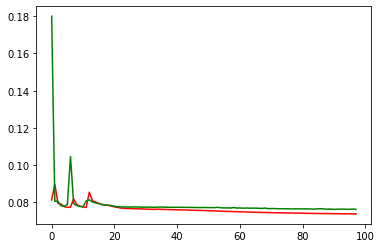

In [ ]:
plt.plot(metric_train[1:epoch], color='r')
plt.plot(metric_valid[1:epoch], color='g')
plt.show()

#### Evaluation by correlation

In [ ]:
def pcorr_vec(X,Y):
  Xnorm = X-X.mean(axis=1).reshape(-1, 1)
  Ynorm = Y-Y.mean(axis=1).reshape(-1, 1)
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma2 = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma2 = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma2,Ysigma2))
  return torch.mean(cov/sigma)

In [ ]:
Va_valid_target = torch.from_numpy(np.load("Va_valid_target.npy").astype('float32')).cuda()

In [ ]:
dense_model.eval()

#pcorr_avg_decomp = np.zeros(shape=len(valid_dataloader))
#pcorr_avg_recomp = np.zeros(shape=len(valid_dataloader))
pcorr_avg_true = np.zeros(shape=len(valid_dataloader))
weights = np.zeros(shape=len(valid_dataloader))

with torch.no_grad():
    for i, (input_val, input_bin, targets_ori) in enumerate(valid_dataloader):

      outputs = dense_model(input_val, input_bin)

      #A_targets = torch.matmul(targets,Va_valid_target)
      #A_outputs = torch.matmul(outputs,Va_valid_target)
      
      weights[i] = outputs.shape[0]
      #pcorr_avg_decomp[i] = pcorr_vec(targets,outputs)
      #pcorr_avg_recomp[i] = pcorr_vec(A_targets,A_outputs)
      pcorr_avg_true[i] = pcorr_vec(targets_ori,outputs)

#score_decomp = round(np.average(pcorr_avg_decomp,weights = weights),6)
#score_recomp = round(np.average(pcorr_avg_recomp,weights = weights),6)
score_true = round(np.average(pcorr_avg_true,weights = weights),6)

#score_decomp, score_recomp, 
score_true

0.66785

In [ ]:
torch.save(dense_model.state_dict(), '/content/drive/MyDrive/dense_model.pt')

## PyTorch Workflow (tSVD, HVGs)

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data.sampler import SubsetRandomSampler

import random
import joblib
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy import stats

import matplotlib.pyplot as plt

Fix random seeds:

In [ ]:
random_seed = 3407
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Prepare files:

In [ ]:
!cp /content/drive/MyDrive/multimodal_tsvd/*.npy /content/

In [ ]:
U_train_input = np.load("U_train_input.npy")
U_train_input_bin = np.load("U_train_input_binary.npy")

U_valid_input = np.load("U_valid_input.npy")
U_valid_input_bin = np.load("U_valid_input_binary.npy")

In [ ]:
!cp /content/drive/MyDrive/multimodal_split/y_train_hvg.npz /content/
!cp /content/drive/MyDrive/multimodal_split/y_test_hvg.npz /content/

In [ ]:
train_target_hvg = sps.load_npz('y_train_hvg.npz')
valid_target_hvg = sps.load_npz('y_test_hvg.npz')

#### Normalize targets (for MSE calculation):

In [ ]:
U_train_input_std = U_train_input.std(axis=1).reshape(-1, 1)
U_train_input_norm = U_train_input / U_train_input_std

In [ ]:
U_valid_input_std = U_valid_input.std(axis=1).reshape(-1, 1)
U_valid_input_norm = U_valid_input / U_valid_input_std

In [ ]:
train_target_hvg = train_target_hvg/train_target_mean.reshape(-1,1)
valid_target_hvg = valid_target_hvg/valid_target_mean.reshape(-1,1)

#### Construct dataset and dataloader:

In [ ]:
class TrainDatasetHVG(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_train_input_norm.astype('float32')).cuda()
      self.inputs_data_bin = torch.from_numpy(U_train_input_bin.astype('float32')).cuda()

      self.targets_data_ori = torch.from_numpy(train_target_hvg.astype('float32'))
      # send to GPU as a whole due to small size.

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = torch.squeeze(self.inputs_data[idx, ...])
      inputs_sliced_bin = torch.squeeze(self.inputs_data_bin[idx, ...])

      targets_ori_sliced = torch.squeeze(self.targets_data_ori[idx, ...]).cuda()

      return inputs_sliced, inputs_sliced_bin, targets_ori_sliced

class ValidDatasetHVG(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_valid_input_norm.astype('float32')).cuda()
      self.inputs_data_bin = torch.from_numpy(U_valid_input_bin.astype('float32')).cuda()

      self.targets_data_ori = torch.from_numpy(valid_target_hvg.astype('float32'))
      # large true data, send accordingly

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = torch.squeeze(self.inputs_data[idx, ...])
      inputs_sliced_bin = torch.squeeze(self.inputs_data_bin[idx, ...])

      targets_ori_sliced = torch.squeeze(self.targets_data_ori[idx, ...]).cuda()

      return inputs_sliced, inputs_sliced_bin, targets_ori_sliced

In [ ]:
batch_size = 256

train_dataloader_hvg = torch.utils.data.DataLoader(TrainDatasetHVG(),
                                               batch_size=batch_size,
                                               shuffle = True)
valid_dataloader_hvg = torch.utils.data.DataLoader(ValidDatasetHVG(), 
                                               batch_size=batch_size,
                                               shuffle = True)

len(train_dataloader_hvg), len(valid_dataloader_hvg)

(332, 83)

#### Construct and train a MLP model:

In [ ]:
class DenseModelHVG(nn.Module):
    def __init__(self,
                 input_size=U_train_input.shape[1],
                 output_size=train_target_hvg.shape[1]):

        super(DenseModelHVG, self).__init__()

        self.dense1 = nn.Sequential(
            nn.Linear(input_size*2, 2048),
            nn.ReLU())
        
        self.dense2 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense3 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense4 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        self.dense5 = nn.Sequential(
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5))
                
        self.dense6 = nn.Sequential(
            nn.Linear(2048, output_size))

    def forward(self, input_val, input_bin):
        output = self.dense1(torch.cat((input_val,input_bin),1))
        output = self.dense2(output)
        output = self.dense3(output)
        output = self.dense4(output)
        output = self.dense5(output)
        output = self.dense6(output)
        return output

In [ ]:
dense_model_hvg = DenseModelHVG().cuda()

In [ ]:
criterion = nn.MSELoss()

num_epochs = 100
learning_rate = 0.003
optimizer = torch.optim.AdamW(params=dense_model_hvg.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
metric_train = np.zeros(shape=num_epochs)
metric_valid = np.zeros(shape=num_epochs)

for epoch in range(num_epochs):
    loss_train = np.zeros(shape=len(train_dataloader_hvg))
    weights_train = np.zeros(shape=len(train_dataloader_hvg))
    
    for i, (inputs_val, inputs_bin, targets_ori) in enumerate(train_dataloader_hvg):
        weights_train[i] = targets_ori.shape[0]

        dense_model_hvg.train()

        outputs = dense_model_hvg(inputs_val, inputs_bin)
        loss = criterion(outputs, targets_ori)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        dense_model_hvg.eval()
        with torch.no_grad():
          outputs = dense_model_hvg(inputs_val, inputs_bin)
          loss_train[i] = criterion(outputs, targets_ori)

    loss_valid = np.zeros(shape=len(valid_dataloader_hvg))
    weights_valid = np.zeros(shape=len(valid_dataloader_hvg))

    with torch.no_grad():
        for i, (inputs_val, inputs_bin, targets_ori) in enumerate(valid_dataloader_hvg):
          weights_valid[i] = targets_ori.shape[0]

          outputs = dense_model_hvg(inputs_val, inputs_bin)
          loss_valid[i] = criterion(outputs, targets_ori)

    metric_train[epoch] = np.average(loss_train, weights=weights_train)
    metric_valid[epoch] = np.average(loss_valid, weights=weights_valid)

    scheduler.step(metric_valid[epoch])

    print('epoch', epoch+1,
          '| train_loss:',round(metric_train[epoch],4),
          '| valid_loss:',round(metric_valid[epoch],4))

epoch 1 | train_loss: 0.1705 | valid_loss: 0.0709
epoch 2 | train_loss: 0.0687 | valid_loss: 0.0921
epoch 3 | train_loss: 0.0741 | valid_loss: 0.0692
epoch 4 | train_loss: 0.0677 | valid_loss: 0.0668
epoch 5 | train_loss: 0.0664 | valid_loss: 0.0671
epoch 6 | train_loss: 0.0665 | valid_loss: 0.0658
epoch 7 | train_loss: 0.0655 | valid_loss: 0.0656
epoch 8 | train_loss: 0.0651 | valid_loss: 0.0665
epoch 9 | train_loss: 0.0659 | valid_loss: 0.067
epoch 10 | train_loss: 0.0673 | valid_loss: 0.0669
epoch 11 | train_loss: 0.0674 | valid_loss: 0.0663
epoch 12 | train_loss: 0.0659 | valid_loss: 0.0658
epoch 13 | train_loss: 0.0654 | valid_loss: 0.0656
epoch 14 | train_loss: 0.0651 | valid_loss: 0.0657
epoch 15 | train_loss: 0.0649 | valid_loss: 0.0654
epoch 16 | train_loss: 0.0647 | valid_loss: 0.0654
epoch 17 | train_loss: 0.0644 | valid_loss: 0.0654
epoch 18 | train_loss: 0.0641 | valid_loss: 0.065
epoch 19 | train_loss: 0.0638 | valid_loss: 0.0651
epoch 20 | train_loss: 0.0635 | valid_loss

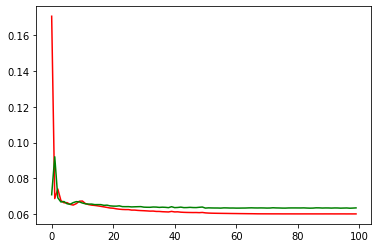

In [ ]:
plt.plot(metric_train, color='r')
plt.plot(metric_valid, color='g')
plt.show()

#### Evaluation by correlation

In [ ]:
def pcorr_vec(X,Y):
  Xnorm = X-X.mean(axis=1).reshape(-1, 1)
  Ynorm = Y-Y.mean(axis=1).reshape(-1, 1)
  cov = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Ynorm,1,0)))
  Xsigma2 = torch.diagonal(torch.matmul(Xnorm,torch.transpose(Xnorm,1,0)))
  Ysigma2 = torch.diagonal(torch.matmul(Ynorm,torch.transpose(Ynorm,1,0)))
  sigma = torch.sqrt(torch.mul(Xsigma2,Ysigma2))
  return torch.mean(cov/sigma)

In [ ]:
dense_model_hvg.eval()

pcorr_avg_true = np.zeros(shape=len(valid_dataloader_hvg))
weights = np.zeros(shape=len(valid_dataloader_hvg))

with torch.no_grad():
    for i, (inputs_val, inputs_bin, targets_ori) in enumerate(valid_dataloader_hvg):

      weights[i] = targets_ori.shape[0]

      outputs = dense_model_hvg(inputs_val, inputs_bin)

      pcorr_avg_true[i] = pcorr_vec(targets_ori,outputs)

score_true = round(np.average(pcorr_avg_true,weights = weights),6)

score_true

0.702209

In [ ]:
torch.save(dense_model_hvg.state_dict(), '/content/drive/MyDrive/dense_model_hvg.pt')

## Final Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as Data

import random
import joblib
import numpy as np
import pandas as pd
import scipy.sparse as sps
from scipy import stats

In [ ]:
random_seed = 3407
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

Prepare files:

In [ ]:
U_valid_input = np.load("/content/drive/MyDrive/multimodal_tsvd/U_valid_input.npy")
valid_target = sps.load_npz('/content/drive/MyDrive/multimodal_split/y_test.npz')
U_valid_input_bin = np.load("/content/drive/MyDrive/multimodal_tsvd/U_valid_input_binary.npy")

In [ ]:
U_valid_input_std = U_valid_input.std(axis=1).reshape(-1, 1)
U_valid_input_norm = U_valid_input / U_valid_input_std

In [ ]:
valid_target_mean = np.ma.mean(np.ma.masked_equal(valid_target.toarray(),0),axis=1).data
valid_target = valid_target/valid_target_mean.reshape(-1,1)

In [ ]:
class ValidDatasetFINAL(Data.Dataset):
    def __init__(self):
      self.inputs_data = torch.from_numpy(U_valid_input_norm.astype('float32')).cuda()
      self.inputs_data_bin = torch.from_numpy(U_valid_input_bin.astype('float32')).cuda()
      self.targets_data_ori = torch.from_numpy(valid_target.astype('float32'))
      # large true data, send accordingly

    def __len__(self):
      return self.inputs_data.shape[0]

    def __getitem__(self, idx):
      inputs_sliced = torch.squeeze(self.inputs_data[idx, ...])
      inputs_sliced_bin = torch.squeeze(self.inputs_data_bin[idx, ...])
      targets_ori_sliced = torch.squeeze(self.targets_data_ori[idx, ...]).cuda()

      return inputs_sliced, inputs_sliced_bin, targets_ori_sliced

valid_dataloader_final = torch.utils.data.DataLoader(ValidDatasetFINAL(), 
                                               batch_size=256,
                                               shuffle = True)

In [ ]:
dense_model = DenseModel().cuda()
dense_model.load_state_dict(torch.load('/content/drive/MyDrive/dense_model.pt'))
dense_model.eval()

dense_model_hvg = DenseModelHVG().cuda()
dense_model_hvg.load_state_dict(torch.load('/content/drive/MyDrive/dense_model_hvg.pt'))
dense_model_hvg.eval()

dense_model, dense_model_hvg

(DenseModel(
   (dense1): Sequential(
     (0): Linear(in_features=1024, out_features=2048, bias=True)
     (1): ReLU()
   )
   (dense2): Sequential(
     (0): Linear(in_features=2048, out_features=2048, bias=True)
     (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.5, inplace=False)
   )
   (dense3): Sequential(
     (0): Linear(in_features=2048, out_features=2048, bias=True)
     (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.5, inplace=False)
   )
   (dense4): Sequential(
     (0): Linear(in_features=2048, out_features=2048, bias=True)
     (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Dropout(p=0.5, inplace=False)
   )
   (dense5): Sequential(
     (0): Linear(in_features=2048, out_features=2048, bias=True)
     (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, 

In [ ]:
hvg_index = np.load('/content/drive/MyDrive/hvg_index.npy', allow_pickle=True)
hvg_index

array(['2', '13', '18', ..., '23316', '23377', '23401'], dtype=object)

In [ ]:
pcorr_avg_true = np.zeros(shape=len(valid_dataloader_hvg))
weights = np.zeros(shape=len(valid_dataloader_hvg))

with torch.no_grad():
    for i, (inputs_val, inputs_bin, targets_ori) in enumerate(valid_dataloader_final):
      
      outputs = dense_model(inputs_val, inputs_bin)
      outputs_hvg = dense_model_hvg(inputs_val, inputs_bin)

      for j in range(outputs_hvg.shape[1]):
        outputs[:,int(hvg_index[j])] = outputs_hvg[:,j]

      weights[i] = targets_ori.shape[0]
      pcorr_avg_true[i] = pcorr_vec(targets_ori,outputs)

score_true = round(np.average(pcorr_avg_true,weights = weights),6)

score_true

0.668379